In [2]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            #print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

In [16]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/'
band_labels = ["B4", "B3", "B2"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

In [17]:
def get_center_pixels(image_data, diag_length=(3,3)):

    drawing = image_data.copy()
    h, w, _ = image_data.shape
    rows, cols = diag_length
    
    center = (round(h/2), round(w/2))

    square = image_data[center[0]-cols:center[0]+cols, center[1]-rows:center[1]+rows]

    cv2.rectangle(drawing, (center[0]-cols, center[1]-rows), (center[0]+cols, center[1]+rows), (255, 255, 255))
    plt.imshow(drawing)

    return square

In [18]:
test = convert_to_eight_bits(images[img_keys[0]])

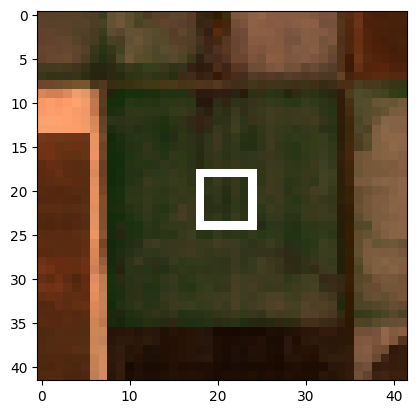

In [19]:
test_region = get_center_pixels(test)

In [20]:
test_region

array([[[38, 44, 19],
        [49, 54, 24],
        [59, 55, 28],
        [49, 54, 27],
        [61, 57, 31],
        [47, 53, 25]],

       [[34, 43, 18],
        [42, 53, 21],
        [55, 58, 28],
        [45, 50, 22],
        [57, 55, 27],
        [42, 50, 22]],

       [[36, 44, 18],
        [48, 53, 25],
        [51, 55, 25],
        [40, 46, 21],
        [55, 56, 27],
        [42, 48, 22]],

       [[39, 46, 21],
        [40, 49, 22],
        [46, 53, 26],
        [36, 45, 18],
        [51, 54, 25],
        [40, 48, 22]],

       [[47, 46, 21],
        [45, 47, 20],
        [41, 50, 21],
        [40, 47, 21],
        [47, 56, 25],
        [43, 48, 24]],

       [[44, 53, 21],
        [45, 53, 24],
        [51, 55, 27],
        [39, 50, 22],
        [56, 59, 29],
        [45, 51, 24]]], dtype=uint8)